##### Authors: Mihika Sonalkar and Sam Reynolds
##### Date: 11/20/24
##### Purpose: Creating the supervised thymoma classification models.

# Importing libraries.

In [22]:
import datetime
import random
import math
import autograd.numpy as np
from autograd import grad
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from statistics import mean, stdev
%matplotlib inline

# Loading data.

In [23]:
betas_file_path = "/Users/samuelreynolds/Desktop/Christensen Lab/Thymoma Classification/Data/combinedBetas_batch_corrected.csv"
pheno_file_path = "/Users/samuelreynolds/Desktop/Christensen Lab/Thymoma Classification/Data/combinedPheno.csv"

combinedBetas_batch_corrected = pd.read_csv(betas_file_path)
combinedPheno = pd.read_csv(pheno_file_path)


combinedBetas_batch_corrected = combinedBetas_batch_corrected.rename(index=combinedBetas_batch_corrected["Unnamed: 0"])
del combinedBetas_batch_corrected["Unnamed: 0"]

combinedPheno = combinedPheno.rename(index=combinedPheno["Unnamed: 0"])
del combinedPheno["Unnamed: 0"]

# Define a mapping of elements to be replaced
replace_dict = {'micronodular': 'M', 'Thymic carcinoma': 'TC'}

# Use the .replace() method to replace elements
combinedPheno['CancerSubtype'] = combinedPheno['CancerSubtype'].replace(replace_dict)


#print("Transposing data.")
combinedBetas_batch_corrected = combinedBetas_batch_corrected.transpose()


In [24]:
# Double checking the rows match and that the beta values are paired with their pheno data
rowNames = list(combinedBetas_batch_corrected.index)
rowNames2 = list(combinedPheno.index)

print (rowNames == rowNames2)

True


In [25]:
combinedPheno_new = combinedPheno[combinedPheno['CancerSubtype'] != 'normal thymus']

In [26]:
combinedPheno_new["CancerSubtype"].replace('atypical A', 'A', inplace=True)

/var/folders/bb/sr6jv42x3zl3mz0gpq05mhwr0000gn/T/ipykernel_48157/2780870193.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combinedPheno_new["CancerSubtype"].replace('atypical A', 'A', inplace=True)
/var/folders/bb/sr6jv42x3zl3mz0gpq05mhwr0000gn/T/ipykernel_48157/2780870193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedPheno

In [27]:
combinedPhenoBetas_new = combinedPheno_new.join(combinedBetas_batch_corrected)

# Building the models.

#### Support vector classification.

In [20]:
#Support Vector Classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

def runSVC(X,Y):        
    """
    # Initialize k-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    """
    # Initialize the classifier
    svc = SVC(kernel='linear', probability=True, random_state=42)
    
    # Performance metrics
    accuracies_train = []
    precisions_train = []
    f1_scores_train = []
    recalls_train = []
    aucs_train = []
    
    accuracies = []
    precisions = []
    f1_scores = []
    recalls = []
    aucs = []

    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Fit the model
    svc.fit(X_train, Y_train)
        
    # Predict probabilities and labels
    Y_pred_train = svc.predict(X_train)
    Y_pred = svc.predict(X_test)
    Y_proba_train = svc.predict(X_train)
    Y_proba = svc.predict_proba(X_test)
        
    #Compute training metrics
    accuracies_train.append(accuracy_score(Y_train, Y_pred_train))
    precisions_train.append(precision_score(Y_train, Y_pred_train, average='weighted'))
    f1_scores_train.append(f1_score(Y_train, Y_pred_train, average='weighted'))
    recalls_train.append(recall_score(Y_train, Y_pred_train, average='weighted'))
    #aucs_train.append(roc_auc_score(Y_train, Y_proba_train, multi_class='ovr'))
        
    # Compute metrics
    accuracies.append(accuracy_score(Y_test, Y_pred))
    precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
    f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
    recalls.append(recall_score(Y_test, Y_pred, average='weighted'))
        
    # For multi-class AUC, use 'ovr' (One-vs-Rest) strategy
    aucs.append(roc_auc_score(Y_test, Y_proba, multi_class='ovr'))
    
    """
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # Fit the model
        svc.fit(X_train, Y_train)
        
        # Predict probabilities and labels
        Y_pred_train = svc.predict(X_train)
        Y_pred = svc.predict(X_test)
        Y_proba_train = svc.predict(X_train)
        Y_proba = svc.predict_proba(X_test)
    
        #Compute training metrics
        accuracies_train.append(accuracy_score(Y_train, Y_pred_train))
        precisions_train.append(precision_score(Y_train, Y_pred_train, average='weighted'))
        f1_scores_train.append(f1_score(Y_train, Y_pred_train, average='weighted'))
        recalls_train.append(recall_score(Y_train, Y_pred_train, average='weighted'))
        #aucs_train.append(roc_auc_score(Y_train, Y_proba_train, multi_class='ovr'))
        
        # Compute test metrics
        accuracies.append(accuracy_score(Y_test, Y_pred))
        precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        recalls.append(recall_score(Y_test, Y_pred, average='weighted'))
        aucs.append(roc_auc_score(Y_test, Y_proba, multi_class='ovr'))
    """
    
    #Calculate train metrics
    mean_accuracy_train = np.mean(accuracies_train)
    mean_precision_train = np.mean(precisions_train)
    mean_f1_train = np.mean(f1_scores_train)
    mean_recall_train = np.mean(recalls_train)
    mean_auc_train = np.mean(aucs_train)
        
    # Calculate mean metrics
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_f1 = np.mean(f1_scores)
    mean_recall = np.mean(recalls)
    mean_auc = np.mean(aucs)
    
    #Display the results
    print(f"Mean Train Accuracy: {mean_accuracy_train}")
    print(f"Mean Train Precision: {mean_precision_train}")
    print(f"Mean Train F1 Score: {mean_f1_train}")
    print(f"Mean Train Recall: {mean_recall_train}")
    #print(f"Mean Train AUC: {mean_auc_train}")
    
    # Display the results
    print()
    print(f"Mean Test Accuracy: {mean_accuracy}")
    print(f"Mean Test Precision: {mean_precision}")
    print(f"Mean Test F1 Score: {mean_f1}")
    print(f"Mean Test Recall: {mean_recall}")
    print(f"Mean Test AUC: {mean_auc}")

    return(mean_accuracy, Y_pred)

#### Extreme gradient boosting classification.

In [90]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

def runXGB(X, Y):
    # Encode the target labels as integers
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    """
    # Initialize k-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    """
    # Initialize the XGBoost classifier
    xgb = XGBClassifier(
        use_label_encoder=False, 
        eval_metric='mlogloss', 
        #max_depth=3, 
        #subsample=0.8, 
        reg_alpha = 1,
        #colsample_bytree=0.8, 
        #n_estimators=100,
        #tree_method='hist',
        random_state=42)
    
    #Performance metrics
    accuracies_train = []
    precisions_train = []
    f1_scores_train = []
    recalls_train = []
    aucs_train = []
    
    # Performance metrics
    accuracies = []
    precisions = []
    f1_scores = []
    recalls = []
    aucs = []

    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

    # Fit the model
    xgb.fit(X_train, Y_train)
        
    # Predict probabilities and labels
    Y_pred_train = xgb.predict(X_train)
    Y_pred = xgb.predict(X_test)
    Y_proba_train = xgb.predict(X_train)
    Y_proba = xgb.predict_proba(X_test)
        
    #Compute training metrics
    accuracies_train.append(accuracy_score(Y_train, Y_pred_train))
    precisions_train.append(precision_score(Y_train, Y_pred_train, average='weighted'))
    f1_scores_train.append(f1_score(Y_train, Y_pred_train, average='weighted'))
    recalls_train.append(recall_score(Y_train, Y_pred_train, average='weighted'))
    #aucs_train.append(roc_auc_score(Y_train, Y_proba_train, multi_class='ovr'))
        
    # Compute metrics
    accuracies.append(accuracy_score(Y_test, Y_pred))
    precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
    f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
    recalls.append(recall_score(Y_test, Y_pred, average='weighted'))
        
    # For multi-class AUC, use 'ovr' (One-vs-Rest) strategy
    aucs.append(roc_auc_score(Y_test, Y_proba, multi_class='ovr'))
    
    """
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y_encoded[train_index], Y_encoded[test_index]
    
        
        # Fit the model
        xgb.fit(X_train, Y_train)
        
        # Predict probabilities and labels
        Y_pred_train = xgb.predict(X_train)
        Y_pred = xgb.predict(X_test)
        Y_proba_train = xgb.predict(X_train)
        Y_proba = xgb.predict_proba(X_test)
        
        #Compute training metrics
        accuracies_train.append(accuracy_score(Y_train, Y_pred_train))
        precisions_train.append(precision_score(Y_train, Y_pred_train, average='weighted'))
        f1_scores_train.append(f1_score(Y_train, Y_pred_train, average='weighted'))
        recalls_train.append(recall_score(Y_train, Y_pred_train, average='weighted'))
        #aucs_train.append(roc_auc_score(Y_train, Y_proba_train, multi_class='ovr'))
        
        # Compute metrics
        accuracies.append(accuracy_score(Y_test, Y_pred))
        precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        recalls.append(recall_score(Y_test, Y_pred, average='weighted'))
        
        # For multi-class AUC, use 'ovr' (One-vs-Rest) strategy
        aucs.append(roc_auc_score(Y_test, Y_proba, multi_class='ovr'))
    """
    #Calculate train metrics
    mean_accuracy_train = np.mean(accuracies_train)
    mean_precision_train = np.mean(precisions_train)
    mean_f1_train = np.mean(f1_scores_train)
    mean_recall_train = np.mean(recalls_train)
    mean_auc_train = np.mean(aucs_train)
    
    # Calculate test metrics
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_f1 = np.mean(f1_scores)
    mean_recall = np.mean(recalls)
    mean_auc = np.mean(aucs)
    
    #Display the results
    print(f"Mean Train Accuracy: {mean_accuracy_train}")
    print(f"Mean Train Precision: {mean_precision_train}")
    print(f"Mean Train F1 Score: {mean_f1_train}")
    print(f"Mean Train Recall: {mean_recall_train}")
    #print(f"Mean Train AUC: {mean_auc_train}")
    
    # Display the results
    print()
    print(f"Mean Accuracy: {mean_accuracy}")
    print(f"Mean Precision: {mean_precision}")
    print(f"Mean F1 Score: {mean_f1}")
    print(f"Mean Recall: {mean_recall}")
    print(f"Mean AUC: {mean_auc}")

    return(mean_accuracy, Y_pred)

### Multilayer perceptron.

In [79]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow

def runMLP(X):
    # Preprocess the target variable (One-Hot Encoding)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_encoded = one_hot_encoder.fit_transform(combinedPhenoBetas_new["CancerSubtype"].values.reshape(-1, 1))
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)
    
    # Define the Multilayer Perceptron model
    model = Sequential([
        Dense(256, activation='relu', input_dim=X_train.shape[1]),  # Input/First layer
        Dropout(0.1),  # Dropout for regularization
        Dense(128, activation='relu'),  # Second layer
        Dropout(0.2),
        Dense(64, activation='relu'),  # Third layer
        Dropout(0.2),
        Dense(Y_train.shape[1], activation='softmax')  # Fifth layer (Output layer)
    ])
    
    # Compile the model
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32)

    # Predict on the test set
    Y_pred_probs = model.predict(X_test)
    
    # Convert the predicted one-hot encoded vectors back to class indices
    Y_pred_class_indices = Y_pred_probs.argmax(axis=1)
    
    # Convert the class indices back to the original string labels
    Y_pred_classes = one_hot_encoder.categories_[0][Y_pred_class_indices]
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, Y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Save the model
    model.save("mlp_model.h5")
    return(accuracy, Y_pred_classes, Y_pred_probs)


### Models just using beta values.

#### Dimentionality reduction.

##### PCA

In [ ]:
from sklearn.decomposition import PCA
#PCA to reduce dimensions - n-components = 200
pca200=PCA(n_components=200)
combinedBetas_batch_corrected_pca200=pca200.fit_transform(combinedPhenoBetas_new.drop(columns=["Age","Sex","CancerType","CancerSubtype"]))

In [ ]:
#PCA to reduce dimensions - n-components = 20
pca20=PCA(n_components=20)
combinedBetas_batch_corrected_pca20=pca20.fit_transform(combinedPhenoBetas_new.drop(columns=["Age","Sex","CancerType","CancerSubtype"]))

In [ ]:
X_20 = combinedBetas_batch_corrected_pca20
X_200 = combinedBetas_batch_corrected_pca200
Y = combinedPhenoBetas_new["CancerSubtype"].values

##### K-Best

In [87]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
X = combinedPhenoBetas_new.drop(columns=["Age","Sex","CancerType","CancerSubtype"])
Y = combinedPhenoBetas_new["CancerSubtype"].values
print(X.shape)
X_Kbest = SelectKBest(k=500).fit_transform(X, Y)
print(X_Kbest.shape)

(200, 371902)
(200, 500)


### Running the models.

#### PCA

In [162]:
# SVC PCA 200
SVC_PCA_200 = runSVC(X_200,Y)

Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.8
Mean Test Precision: 0.85
Mean Test F1 Score: 0.8074603174603174
Mean Test Recall: 0.8
Mean Test AUC: 0.967425566656709


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [163]:
# SVC PCA 20
SVC_PCA_20 = runSVC(X_20,Y)

Mean Train Accuracy: 0.93125
Mean Train Precision: 0.9323240599593495
Mean Train F1 Score: 0.9307997229064039
Mean Train Recall: 0.93125

Mean Test Accuracy: 0.625
Mean Test Precision: 0.7233333333333334
Mean Test F1 Score: 0.6362213950923629
Mean Test Recall: 0.625
Mean Test AUC: 0.9566531615552353


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [164]:
# XGB PCA 200
XGB_PCA_200 = runXGB(X_200,Y)

/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:49:41] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Accuracy: 0.675
Mean Precision: 0.7148901098901098
Mean F1 Score: 0.6831109742747674
Mean Recall: 0.675
Mean AUC: 0.9415442816261395


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [165]:
# XGB PCA 20
XGB_PCA_20 = runXGB(X_20,Y)

/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:49:56] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Accuracy: 0.65
Mean Precision: 0.6802380952380952
Mean F1 Score: 0.6568055555555556
Mean Recall: 0.65
Mean AUC: 0.9094505245084313


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [234]:
# MLP PCA 200
MLP_PCA_200 = runMLP(X_200)

Epoch 1/50
5/5 [==============================] - 1s 55ms/step - loss: 2.1111 - accuracy: 0.1937 - val_loss: 1.7677 - val_accuracy: 0.3750
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.7071 - accuracy: 0.2875 - val_loss: 1.7716 - val_accuracy: 0.3000
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.5469 - accuracy: 0.4062 - val_loss: 1.7483 - val_accuracy: 0.3000
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.3430 - accuracy: 0.5188 - val_loss: 1.7263 - val_accuracy: 0.2750
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 1.2179 - accuracy: 0.6250 - val_loss: 1.7069 - val_accuracy: 0.3500
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 1.0560 - accuracy: 0.7125 - val_loss: 1.7083 - val_accuracy: 0.3750
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.9230 - accuracy: 0.7937 - val_loss: 1.7223 - val_accuracy: 0.3500
Epoch 8/50
5/5 [===========

In [260]:
# MLP PCA 20
MLP_PCA_20 = runMLP(X_20)

Epoch 1/50
5/5 [==============================] - 1s 59ms/step - loss: 1.9516 - accuracy: 0.2688 - val_loss: 1.8437 - val_accuracy: 0.4750
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.8128 - accuracy: 0.4000 - val_loss: 1.7468 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.6950 - accuracy: 0.5375 - val_loss: 1.6479 - val_accuracy: 0.6000
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.5567 - accuracy: 0.5562 - val_loss: 1.5179 - val_accuracy: 0.6500
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 1.4535 - accuracy: 0.6313 - val_loss: 1.3812 - val_accuracy: 0.7500
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 1.2776 - accuracy: 0.6062 - val_loss: 1.2459 - val_accuracy: 0.7500
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 1.1884 - accuracy: 0.6500 - val_loss: 1.1253 - val_accuracy: 0.7500
Epoch 8/50
5/5 [===========

In [265]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_pred = MLP_PCA_20[1]
Y_prob = MLP_PCA_20[2]
print("Precision: ", precision_score(Y_test, Y_pred, average='weighted'))
print("F1: ", f1_score(Y_test, Y_pred, average='weighted'))
print("Recall: ", recall_score(Y_test, Y_pred, average='weighted'))
print("AUC: ", roc_auc_score(Y_test, Y_prob, multi_class="ovr"))

Precision:  0.7841666666666666
F1:  0.7301587301587302
Recall:  0.725
AUC:  0.917480616357496


#### K-best

In [88]:
# SVC K-best 500
SVC_Kbest_500 = runSVC(X_Kbest,Y)

Mean Train Accuracy: 0.9625
Mean Train Precision: 0.9655657679738562
Mean Train F1 Score: 0.9628031356837082
Mean Train Recall: 0.9625

Mean Test Accuracy: 0.8
Mean Test Precision: 0.8391666666666667
Mean Test F1 Score: 0.8077629113717825
Mean Test Recall: 0.8
Mean Test AUC: 0.9840289303327443


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [91]:
# XGB K-best 500
XGB_Kbest_500 = runXGB(X_Kbest,Y)

/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:23:37] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Accuracy: 0.75
Mean Precision: 0.8183333333333334
Mean F1 Score: 0.7600870455709166
Mean Recall: 0.75
Mean AUC: 0.9479831298026483


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [96]:
# MLP K-best 500
MLP_Kbest_500 = runMLP(X_Kbest)

Epoch 1/100
5/5 [==============================] - 1s 51ms/step - loss: 1.9070 - accuracy: 0.2625 - val_loss: 1.1659 - val_accuracy: 0.6000
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 1.2920 - accuracy: 0.5562 - val_loss: 0.9819 - val_accuracy: 0.6250
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 1.0971 - accuracy: 0.6187 - val_loss: 0.9404 - val_accuracy: 0.6500
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.9972 - accuracy: 0.6250 - val_loss: 0.7049 - val_accuracy: 0.7500
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 0.9616 - accuracy: 0.6750 - val_loss: 0.9135 - val_accuracy: 0.7000
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.8413 - accuracy: 0.7188 - val_loss: 0.7407 - val_accuracy: 0.7500
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 0.8145 - accuracy: 0.7188 - val_loss: 0.6345 - val_accuracy: 0.7750
Epoch 8/100
5/5 [===

In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_pred = MLP_Kbest_500[1]
Y_prob = MLP_Kbest_500[2]
print("Accuracy: ", MLP_Kbest_500[0])
print("Precision: ", precision_score(Y_test, Y_pred, average='weighted'))
print("F1: ", f1_score(Y_test, Y_pred, average='weighted'))
print("Recall: ", recall_score(Y_test, Y_pred, average='weighted'))
print("AUC: ", roc_auc_score(Y_test, Y_prob, multi_class="ovr"))

Accuracy:  0.8500000238418579
Precision:  0.8811904761904762
F1:  0.8556535947712419
Recall:  0.85
AUC:  0.9853853575301853


### Plotting confusion matrix.

In [98]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=Y_test, y_pred=MLP_Kbest_500[1], labels=np.unique(Y_test).tolist())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                               display_labels=np.unique(Y_test).tolist())

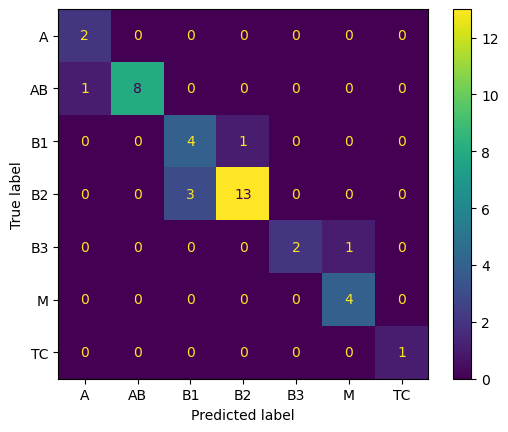

In [99]:
disp.plot()
plt.show()

In [51]:
k = range(0,600,10)
test_accuracies = []
X = combinedPhenoBetas_new.drop(columns=["Age","Sex","CancerType","CancerSubtype"])
Y = combinedPhenoBetas_new["CancerSubtype"].values
for i in k:
    X_Kselected = SelectKBest(k=i+1).fit_transform(X, Y)
    test_accuracy = runMLP(X_Kselected)[0]
    test_accuracies.append(test_accuracy)
print(test_accuracies)

Epoch 1/50
5/5 [==============================] - 1s 51ms/step - loss: 1.9149 - accuracy: 0.2000 - val_loss: 1.9003 - val_accuracy: 0.4000
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.8686 - accuracy: 0.2875 - val_loss: 1.8607 - val_accuracy: 0.4000
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.8344 - accuracy: 0.2562 - val_loss: 1.8153 - val_accuracy: 0.4250
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.7905 - accuracy: 0.3125 - val_loss: 1.7625 - val_accuracy: 0.4250
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 1.7540 - accuracy: 0.2812 - val_loss: 1.7073 - val_accuracy: 0.4250
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 1.6933 - accuracy: 0.3313 - val_loss: 1.6527 - val_accuracy: 0.3000
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 1.6705 - accuracy: 0.3187 - val_loss: 1.6073 - val_accuracy: 0.2500
Epoch 8/50
5/5 [===========

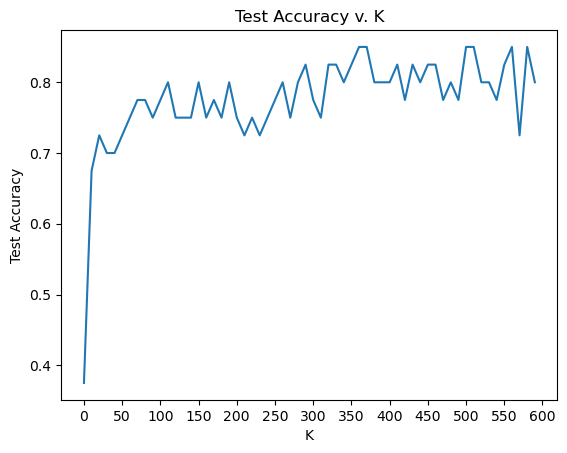

In [101]:
plt.plot(k, test_accuracies)
plt.xlabel('K')
plt.ylabel('Test Accuracy')
plt.xticks(range(0,650,50))
plt.title('Test Accuracy v. K')
plt.show()

In [33]:
from sklearn.decomposition import PCA
Y = combinedPhenoBetas_new["CancerSubtype"].values
pcs = range(20,200,20)
test_accuracies_pc = []
print("Starting")
for pc in pcs:
    print(pc)
    pc=PCA(n_components=pc)
    combinedBetas_batch_corrected_pca = pc.fit_transform(combinedPhenoBetas_new.drop(columns=["Age","Sex","CancerType","CancerSubtype"]))
    print("Running SVC model")
    test_accuracy = runSVC(combinedBetas_batch_corrected_pca,Y)[0]
    test_accuracies_pc.append(test_accuracy)
print(test_accuracies_pc)

Starting
20
Running SVC model
Mean Train Accuracy: 0.95
Mean Train Precision: 0.9503063725490195
Mean Train F1 Score: 0.9496902129104224
Mean Train Recall: 0.95

Mean Test Accuracy: 0.625
Mean Test Precision: 0.7126190476190476
Mean Test F1 Score: 0.6334436173145852
Mean Test Recall: 0.625
Mean Test AUC: 0.9492692568048801
40


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running SVC model
Mean Train Accuracy: 0.99375
Mean Train Precision: 0.9938888888888888
Mean Train F1 Score: 0.9937445279439661
Mean Train Recall: 0.99375

Mean Test Accuracy: 0.6
Mean Test Precision: 0.6241666666666666
Mean Test F1 Score: 0.5908550947260625
Mean Test Recall: 0.6
Mean Test AUC: 0.9356867578724388
60


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running SVC model
Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.675
Mean Test Precision: 0.6915476190476191
Mean Test F1 Score: 0.6725118407578086
Mean Test Recall: 0.675
Mean Test AUC: 0.9195133256502405
80


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running SVC model
Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.625
Mean Test Precision: 0.6483333333333333
Mean Test F1 Score: 0.6211422095720008
Mean Test Recall: 0.625
Mean Test AUC: 0.9192961500033868
100


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running SVC model
Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.6
Mean Test Precision: 0.6198809523809523
Mean Test F1 Score: 0.5969934640522876
Mean Test Recall: 0.6
Mean Test AUC: 0.9390596545100244
120


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running SVC model
Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.675
Mean Test Precision: 0.7320833333333334
Mean Test F1 Score: 0.6852474323062558
Mean Test Recall: 0.675
Mean Test AUC: 0.9245514713632589
140


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running SVC model
Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.675
Mean Test Precision: 0.7291666666666667
Mean Test F1 Score: 0.6758772326134755
Mean Test Recall: 0.675
Mean Test AUC: 0.9366055481523586
160


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running SVC model
Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.675
Mean Test Precision: 0.716378205128205
Mean Test F1 Score: 0.6815528510254676
Mean Test Recall: 0.675
Mean Test AUC: 0.9282246713901454
180


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running SVC model
Mean Train Accuracy: 1.0
Mean Train Precision: 1.0
Mean Train F1 Score: 1.0
Mean Train Recall: 1.0

Mean Test Accuracy: 0.65
Mean Test Precision: 0.6819047619047619
Mean Test F1 Score: 0.6452598566308245
Mean Test Recall: 0.65
Mean Test AUC: 0.9250967294257979
[0.625, 0.6, 0.675, 0.625, 0.6, 0.675, 0.675, 0.675, 0.65]


/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
plt.plot(pcs, test_accuracies_pc)
plt.xlabel('# Principal Components')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title('Test Accuracy v. # Principal Components')
plt.show()

/opt/anaconda3/envs/MED264FinalProject/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.